# Previsão de demanda energética

Previsão de 1 hora na frente utilizando apenas uma rede LSTM com janela de 24H.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import seaborn as sb
import statsmodels.api as sm


C:\Users\Pedro\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Carregar dataset residencial

In [2]:
casas = {}
for i, filePath in enumerate(sorted(glob.glob('Residencia/*.csv'))):
    casas[i] = pd.read_csv(filePath).filter(['date', 'activeEnergy', 'cepa', 'cepb', 'cepc'])
    #casas[i] = casas[i].dropna(axis = 'columns', how = 'all')
    casas[i]['date'] = pd.to_datetime(casas[i]['date'], yearfirst=True, dayfirst= True, errors = 'coerce')
    casas[i]['weekDay'] = casas[i]['date'].dt.weekday
    casas[i]['hours'] = casas[i]['date'].dt.hour
    casas[i]['EnergyNextHour'] = casas[i]['activeEnergy'].shift(-1)
    casas[i]['EnergyNext2Hours'] = casas[i]['activeEnergy'].shift(-2)
    casas[i].drop(casas[i].index[-3:], inplace = True)
    #casas[i].dropna(axis = 0, how = 'any', inplace = True)
    
    #casas[i] = casas[i][casas[i]['activeEnergy'] < 4*casas[i]['activeEnergy'].std()]

In [3]:
a = 2

In [4]:
print(pd.isnull(casas[a]).any())
#df.loc[df['column_name'] == some_value]

casas[a].head()

date                False
activeEnergy        False
cepa                False
cepb                False
cepc                False
weekDay             False
hours               False
EnergyNextHour      False
EnergyNext2Hours    False
dtype: bool


,date,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours
0,2017-03-01 00:00:00,1408,192,548,668,2,0,1316.0,1297.0
1,2017-03-01 01:00:00,1316,184,512,620,2,1,1297.0,1278.0
2,2017-03-01 02:00:00,1297,171,509,617,2,2,1278.0,1279.0
3,2017-03-01 03:00:00,1278,174,499,605,2,3,1279.0,1239.0
4,2017-03-01 04:00:00,1279,187,492,600,2,4,1239.0,1255.0


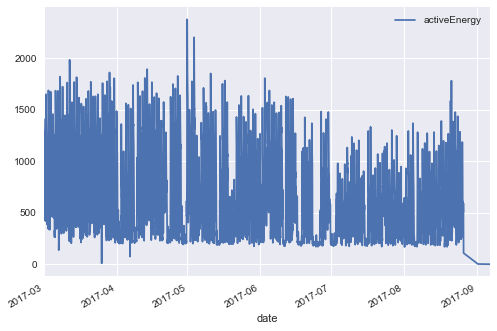

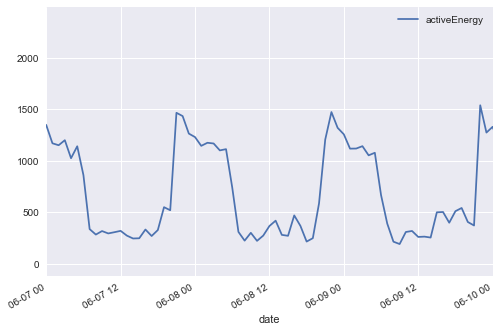

In [5]:
casas[a].plot(x = 'date', y = ['activeEnergy'])#, xlim = ['2017-03-01 00:00:00', ['2017-03-02 00:00:00']])
plt.show()
casas[a].plot(x = 'date', y = ['activeEnergy'], xlim = ['2017-06-07 00:00:00', ['2017-06-10 00:00:00']])
plt.show()

## Truncar os dados

In [6]:
train_set = casas[a][casas[a]['date'] < '2017-08-15 00:00:00']
test_set = casas[a][casas[a]['date'] > '2017-08-15 00:00:00']#.reset_index()

## Retirar tendência

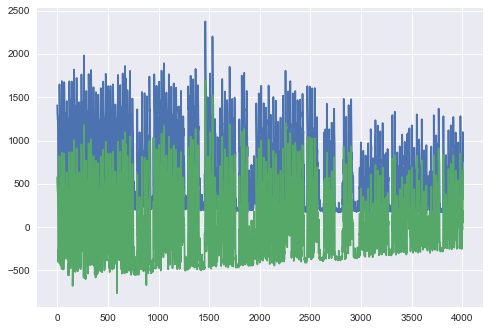

In [7]:
from sklearn.linear_model import LinearRegression
linearReg = LinearRegression()
#print(train_set.index.shape, train_set['activeEnergy'].shape)
linearReg.fit(train_set.index[:, np.newaxis], train_set['activeEnergy'])
train_set_without_tendency = train_set['activeEnergy'] - linearReg.predict(train_set.index[:, np.newaxis])
plt.plot(train_set['activeEnergy'])
plt.plot(train_set_without_tendency)
plt.show()

In [8]:
F = train_set.set_index('date')
#print(F.index.freq)
s = sm.tsa.seasonal_decompose(F.activeEnergy)

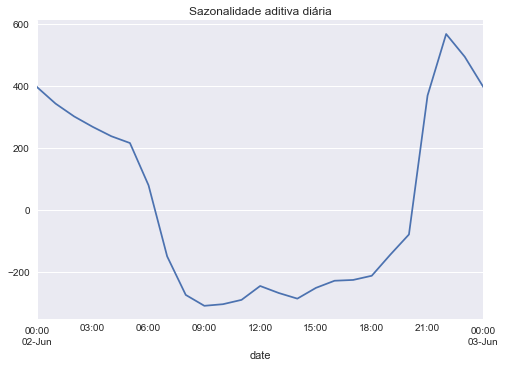

In [9]:
s.seasonal.plot(xlim = ['2017-06-02', '2017-06-03'])
plt.title('Sazonalidade aditiva diária')
plt.show()

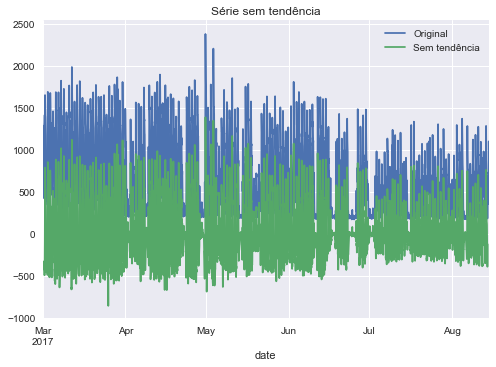

In [10]:
train_set_without_tendency = train_set.set_index('date')['activeEnergy'] - s.trend
train_set.set_index('date').plot(y = ['activeEnergy'])
train_set_without_tendency.plot()
plt.title('Série sem tendência')
plt.legend(['Original', 'Sem tendência'])
plt.show()

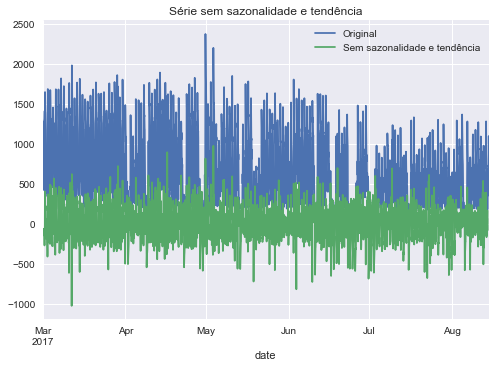

In [11]:
train_set_without_season = train_set_without_tendency - s.seasonal
train_set.set_index('date').plot(y = ['activeEnergy'])
train_set_without_season.plot()
plt.legend(['Original', 'Sem sazonalidade e tendência'])
plt.title('Série sem sazonalidade e tendência')
plt.show()


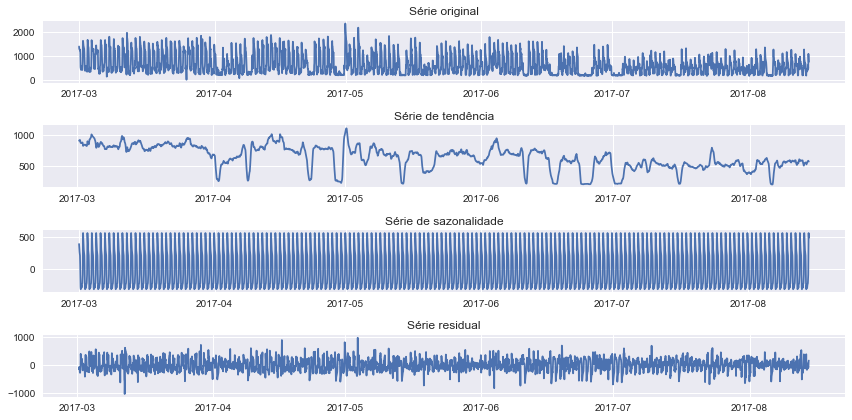

In [12]:
fig, axes = plt.subplots(4,1, figsize = (12, 6))
axes[0].plot(train_set.set_index('date')['activeEnergy'])
axes[0].set_title('Série original')
axes[1].plot(s.trend)
axes[1].set_title('Série de tendência')
axes[2].plot(s.seasonal)
axes[2].set_title('Série de sazonalidade')
axes[3].plot(s.resid)
axes[3].set_title('Série residual')
plt.tight_layout()
plt.show()

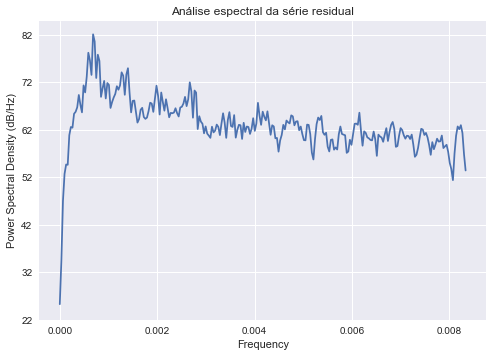

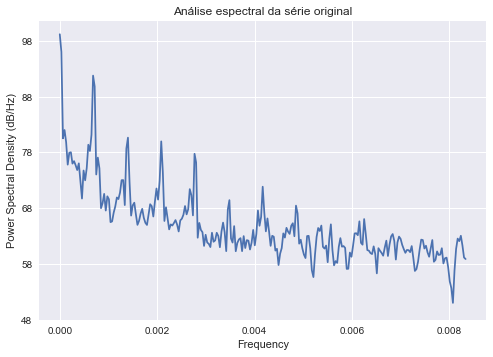

In [13]:
plt.psd(s.resid.dropna(), NFFT = 512, Fs = 1/60)
plt.title('Análise espectral da série residual')
plt.show()
plt.psd(F.activeEnergy.dropna(), NFFT = 512, Fs = 1/60)
plt.title('Análise espectral da série original')
plt.show()

In [14]:
train_set.set_index('date', inplace = True)
train_set['ResidualSeries'] = s.resid
train_set['SeasonalSeries'] = s.seasonal
train_set['TrendSeries'] = s.trend
train_set.dropna(axis = 0, how = 'any', inplace = True)
train_set.head()

C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours,ResidualSeries,SeasonalSeries,TrendSeries
date,,,,,,,,,,,
2017-03-01 12:00:00,513,273,33,207,2,12,575.0,483.0,-144.006249,-245.827084,902.833333
2017-03-01 13:00:00,575,335,40,200,2,13,483.0,550.0,-61.558834,-268.503666,905.062500
2017-03-01 14:00:00,483,307,38,138,2,14,550.0,446.0,-139.123970,-286.688530,908.812500
2017-03-01 15:00:00,550,301,8,241,2,15,446.0,418.0,-110.017670,-251.898997,911.916667
2017-03-01 16:00:00,446,294,5,147,2,16,418.0,420.0,-239.082931,-228.896236,913.979167


In [15]:
test_set.set_index('date', inplace = True)
test_set = test_set[:'2017-08-26']
print(test_set.index.freq)
test_set.tail()

None


,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours
date,,,,,,,,
2017-08-26 06:00:00,537,159,158,220,5,6,505.0,591.0
2017-08-26 07:00:00,505,142,101,262,5,7,591.0,430.0
2017-08-26 08:00:00,591,298,40,253,5,8,430.0,108.0
2017-08-26 09:00:00,430,261,-1,170,5,9,108.0,2.0
2017-08-26 10:00:00,108,82,6,20,5,10,2.0,0.0


In [16]:
#test_set.set_index('date', inplace = True)
F = test_set.activeEnergy
sTest = sm.tsa.seasonal_decompose(F, freq = 24)
test_set['ResidualSeries'] = sTest.resid
test_set['SeasonalSeries'] = sTest.seasonal
test_set['TrendSeries'] = sTest.trend
test_set.dropna(axis = 0, how = 'any', inplace = True)
test_set.head()

,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours,ResidualSeries,SeasonalSeries,TrendSeries
date,,,,,,,,,,,
2017-08-15 13:00:00,228,146,24,58,1,13,225.0,435.0,74.418868,-350.439702,504.020833
2017-08-15 14:00:00,225,182,10,33,1,14,435.0,594.0,75.894247,-357.435914,506.541667
2017-08-15 15:00:00,435,348,37,50,1,15,594.0,259.0,132.005990,-208.443490,511.437500
2017-08-15 16:00:00,594,371,44,179,1,16,259.0,259.0,302.038187,-222.559020,514.520833
2017-08-15 17:00:00,259,207,10,42,1,17,259.0,297.0,-42.637950,-212.028717,513.666667


## Pré processamento dos dados

In [17]:
matrix =  casas[a].as_matrix(columns = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 
                                        'hours', 'EnergyNextHour', 'EnergyNext2Hours']).T
print(matrix.shape)
correlationCoef = np.corrcoef(matrix[:,3:])

(8, 4311)


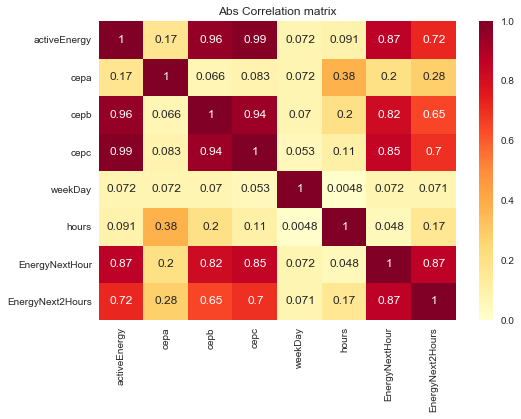

In [18]:
sb.heatmap(np.abs(correlationCoef),
           annot=True, cmap = 'YlOrRd', vmin = 0, vmax =  1,
          xticklabels = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 'hours', 'EnergyNextHour', 'EnergyNext2Hours'],
          yticklabels = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 'hours', 'EnergyNextHour', 'EnergyNext2Hours'])
plt.title('Abs Correlation matrix')
plt.show()

## Regressão com Long Term Short Memory

In [19]:
from keras.models import Sequential
from keras.layers import Dense

Using Theano backend.


In [20]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])

    return np.array(dataX), np.array(dataY)

In [21]:
train_set.shape
#create_dataset(train_series, look_back = 6)

(3984, 11)

In [22]:
look_back  = 24

In [23]:
#len(train_set['ResidualSeries'].values)
train_values = train_set['ResidualSeries'].values
train_mean = train_set['ResidualSeries'].mean()
train_std = train_set['ResidualSeries'].std()
train_values -= train_mean
train_values /= train_std


test_values = test_set['ResidualSeries'].values
test_mean = test_set['ResidualSeries'].mean()
test_std = test_set['ResidualSeries'].std()
test_values -= test_mean
test_values /= test_std

x, y = create_dataset(train_values, look_back = look_back)
testx, testy = create_dataset(test_values, look_back = look_back)
print(y[:10], '\n',train_values[:30])
x = x[:,:,np.newaxis]
print(x.shape, y.shape)

[-0.35709459 -0.25653214 -0.42163336 -0.03898609 -0.39360436 -0.56522024
 -0.76401475 -1.21305471 -1.97099445 -1.6775358 ] 
 [-0.69117614 -0.29497605 -0.66771441 -0.52784442 -1.14806603 -1.29195024
 -1.30082785 -0.78276327 -0.0438935   1.9399958   1.04458519  0.9207727
  0.79001312  0.9148545   1.07973498  0.95330323  1.04975314  0.37075477
 -0.41676937 -0.76602548 -0.88858594 -0.54406535 -0.61124328  0.27324219
 -0.35709459 -0.25653214 -0.42163336 -0.03898609 -0.39360436 -0.56522024]
(3959, 24, 1) (3959,)


In [24]:
from keras.regularizers import l2
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(units = 30,
               activation = 'tanh',
               batch_input_shape = (32, x.shape[1], x.shape[2]),
               stateful = True,
               recurrent_dropout = 0.25,
            )
         )
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [25]:
history = {'loss': [], 'val_loss': []}
for i in range(175):
    hist = model.fit(x[:3200], y[:3200], 
                    validation_data=(x[3200:3936], y[3200:3936]),
                    epochs = 1, 
                    batch_size = 32, 
                    verbose =  2)
    history['loss'].append(hist.history['loss'])
    history['val_loss'].append(hist.history['val_loss'])
    model.reset_states()
    

Train on 3200 samples, validate on 736 samples
Epoch 1/1
3s - loss: 0.8303 - val_loss: 0.4411
Train on 3200 samples, validate on 736 samples
Epoch 1/1
3s - loss: 0.6196 - val_loss: 0.4203
Train on 3200 samples, validate on 736 samples
Epoch 1/1
3s - loss: 0.5749 - val_loss: 0.4080
Train on 3200 samples, validate on 736 samples
Epoch 1/1
3s - loss: 0.5572 - val_loss: 0.4020
Train on 3200 samples, validate on 736 samples
Epoch 1/1
3s - loss: 0.5383 - val_loss: 0.3906
Train on 3200 samples, validate on 736 samples
Epoch 1/1
3s - loss: 0.5241 - val_loss: 0.3871
Train on 3200 samples, validate on 736 samples
Epoch 1/1
3s - loss: 0.5232 - val_loss: 0.3821
Train on 3200 samples, validate on 736 samples
Epoch 1/1
3s - loss: 0.5168 - val_loss: 0.3762
Train on 3200 samples, validate on 736 samples
Epoch 1/1
3s - loss: 0.5013 - val_loss: 0.3758
Train on 3200 samples, validate on 736 samples
Epoch 1/1
3s - loss: 0.4995 - val_loss: 0.3677
Train on 3200 samples, validate on 736 samples
Epoch 1/1
3s 

5s - loss: 0.4329 - val_loss: 0.3663
Train on 3200 samples, validate on 736 samples
Epoch 1/1
5s - loss: 0.4324 - val_loss: 0.3658
Train on 3200 samples, validate on 736 samples
Epoch 1/1
6s - loss: 0.4283 - val_loss: 0.3808
Train on 3200 samples, validate on 736 samples
Epoch 1/1
5s - loss: 0.4359 - val_loss: 0.3711
Train on 3200 samples, validate on 736 samples
Epoch 1/1
5s - loss: 0.4320 - val_loss: 0.3661
Train on 3200 samples, validate on 736 samples
Epoch 1/1
6s - loss: 0.4205 - val_loss: 0.3690
Train on 3200 samples, validate on 736 samples
Epoch 1/1
6s - loss: 0.4253 - val_loss: 0.3777
Train on 3200 samples, validate on 736 samples
Epoch 1/1
5s - loss: 0.4207 - val_loss: 0.3769
Train on 3200 samples, validate on 736 samples
Epoch 1/1
5s - loss: 0.4243 - val_loss: 0.3747
Train on 3200 samples, validate on 736 samples
Epoch 1/1
5s - loss: 0.4305 - val_loss: 0.3709
Train on 3200 samples, validate on 736 samples
Epoch 1/1
5s - loss: 0.4239 - val_loss: 0.3786
Train on 3200 samples, 

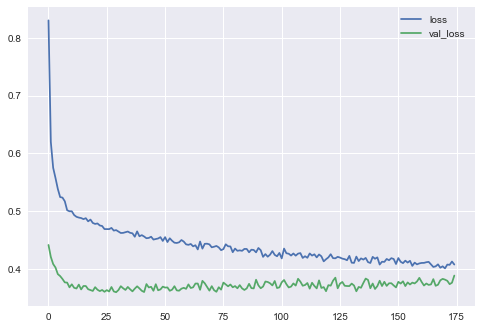

In [26]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
testx.shape

(224, 24)

In [28]:
predictedTest = model.predict(testx[:,:,np.newaxis])

ploting = predictedTest*test_std + test_mean 
ploting += test_set['SeasonalSeries'].values[23:-2, np.newaxis] + test_set['TrendSeries'].values[23:-2, np.newaxis]
print(test_std, test_mean)
print(test_set['SeasonalSeries'].values.shape, test_set['TrendSeries'].values.shape)
print(predictedTest.shape, ploting.shape)


178.1663610617089 3.8393229166667258
(249,) (249,)
(224, 1) (224, 1)


In [29]:
from sklearn.metrics import mean_absolute_error
print('Mean absolute error for residual series: %.4f'%mean_absolute_error(predictedTest, testy))
print('Mean absolute error for complete series: %.4f'%mean_absolute_error(ploting, test_set['activeEnergy'][23:-2].values))

Mean absolute error for residual series: 0.6291
Mean absolute error for complete series: 68.9539


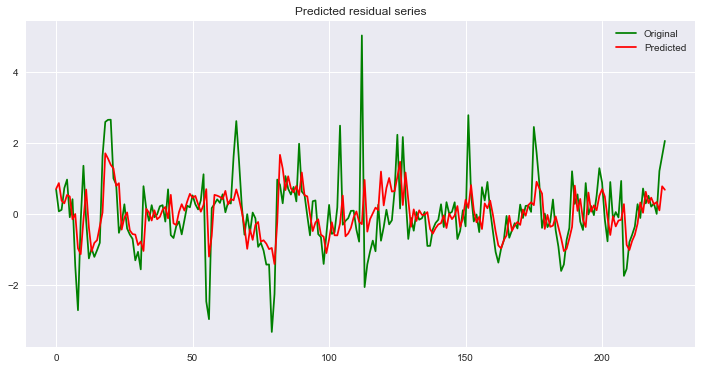

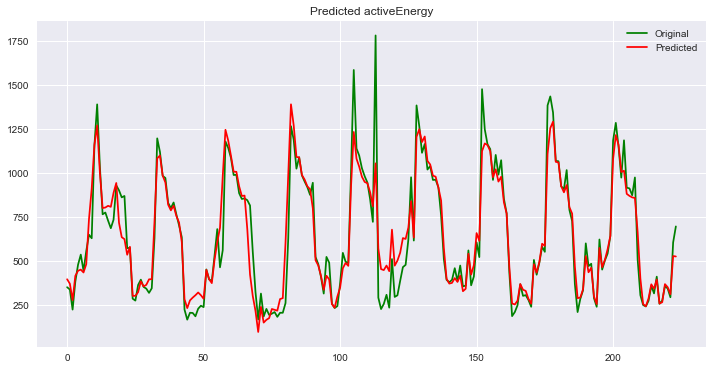

In [30]:
plt.figure(figsize = (12,6))
plt.title('Predicted residual series')
#plt.plot(test_set['ResidualSeries'][23:-2].values, 'g')
plt.plot(testy, 'g')
plt.plot(predictedTest, 'r')
plt.legend(['Original', 'Predicted'])
plt.show()

plt.figure(figsize = (12,6))
plt.title('Predicted activeEnergy')
plt.plot(test_set['activeEnergy'][23:-2].values, 'g')
plt.plot(ploting, 'r')
plt.legend(['Original', 'Predicted'])
#plt.text('MSE %.3f'%)
plt.show()
